In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from skimage.measure import block_reduce
from tqdm import tqdm

In [2]:
# Function: Load image
def load_image(path):
    return np.array(Image.open(path))

# Function: Black padding (to make same dimensional image)
def pad_to_square(image):
    height, width, _ = image.shape
    
    # Check if it is not odd number. Then, it can be padded to square
    # Ex: 510x351 this function will pad to 510x509
    # The process is 510-351=159, 159/2=79.5 -> 79, Padding top and bottom 79+351+79=509
    if (height - width) % 2 == 0:
        # Pad image
        padding = abs(height - width) // 2
        if height == width:
            return image
        elif height > width:
            padded_image = cv2.copyMakeBorder(image, 0, 0, padding, padding, cv2.BORDER_CONSTANT, value=[0, 0, 0])
        else:
            padded_image = cv2.copyMakeBorder(image, padding, padding, 0, 0, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    
    # If it is odd number, image will be upsampled using duplicating method (Ex: [1] to [[1 ,1], [1, 1]]) 
    # To make it shape even numbers (510x351 -> 1020x702)
    # Then pad the image (1020x702 -> 1020x1020)
    # After padded, image will be downsampling using meanpooling method (Ex: [[0, 0], [2, 2]] to [1])
    # To make it shape back to what we want (1020x1020 -> 510x510)
    else:
        # Upsample using duplicating method
        image = np.repeat(image, 2, axis=1).repeat(2, axis=0)
        # Pad image
        height, width, _ = image.shape
        padding = abs(height - width) // 2
        if height == width:
            return image
        elif height > width:
            padded_image = cv2.copyMakeBorder(image, 0, 0, padding, padding, cv2.BORDER_CONSTANT, value=[0, 0, 0])
        else:
            padded_image = cv2.copyMakeBorder(image, padding, padding, 0, 0, cv2.BORDER_CONSTANT, value=[0, 0, 0])
        # Downsample using meanpooling method
        padded_image = block_reduce(padded_image, (2,2,1), np.mean).astype('uint8')
    
    return padded_image

# Function: load, pad, and store all images from folder into list
def load_padded_images(folder_path):
    images_list = []

    for filename in tqdm(os.listdir(folder_path)):
        if filename.endswith('.png'):
            image_path = os.path.join(folder_path, filename)
            images_list.append(pad_to_square(load_image(image_path)))

    print(f"{len(images_list)} images have been successfully loaded and padded from {folder_path}.")
    return images_list

# Function: Scale image down using bicubic interpolation
def scale_down_images(images, factor):
    images_list = []
    for image in tqdm(images):
        image = cv2.resize(image, dsize=(0, 0), fx=1/factor, fy=1/factor, interpolation=cv2.INTER_CUBIC)
        images_list.append(image)

    print(f"{len(images_list)} images have been successfully scaled down.")
    return images_list

def preprocessing_images(folder_path, scaling_factor, save_folder, save_file_name):
    save_file_path = os.path.join(save_folder, save_file_name)
    if os.path.exists(save_file_path):
        print("File exist.")
    else:
        images_padded = load_padded_images(folder_path)

        # Scale down for making model easier to train and validate.
        images_padded_downsize = scale_down_images(images_padded, scaling_factor)

        # Convert to numpy array
        images_padded_downsize_np = np.stack(images_padded_downsize, axis=0)
        print(f"List of images have been successfully converted to numpy array with shape of {images_padded_downsize_np.shape}.")

        # Store in local
        np.save(save_file_path, images_padded_downsize_np)
        print("Numpy array saved!")

In [3]:
datasets_path = '../Datasets'
scaling_factor = 2

In [4]:
hr_train_folder_path = '../Datasets/HR_train'
scaling_factor = 2
hr_train_file_name = 'hr_images_train.npy'


preprocessing_images(hr_train_folder_path, scaling_factor, datasets_path, hr_train_file_name)

File exist.


In [5]:
hr_val_folder_path = '../Datasets/HR_val'
hr_val_file_name = 'hr_images_val.npy'

preprocessing_images(hr_val_folder_path, scaling_factor, datasets_path, hr_val_file_name)

File exist.


In [8]:
lr_un_train_folder_path = '../Datasets/X4_un_train'
lr_un_train_file_name = 'lr_images_un_train.npy'

preprocessing_images(lr_un_train_folder_path, scaling_factor, datasets_path, lr_un_train_file_name)

File exist.


In [9]:
lr_un_val_folder_path = '../Datasets/X4_un_val'
lr_un_val_file_name = 'lr_images_un_val.npy'

preprocessing_images(lr_un_val_folder_path, scaling_factor, datasets_path, lr_un_val_file_name)

File exist.


In [10]:
hr_images_train = np.load(os.path.join(datasets_path, hr_train_file_name))
hr_images_val = np.load(os.path.join(datasets_path, hr_val_file_name))
print("High resolution images loaded!")

High resolution images loaded!


In [12]:
lr_un_images_train = np.load(os.path.join(datasets_path, lr_un_train_file_name))
lr_un_images_val = np.load(os.path.join(datasets_path, lr_un_val_file_name))
print("Low resolution images loaded!")

Low resolution images loaded!


In [13]:
def show_sample_images(hr_images, lr_images, sample_images=3, start=0):
# Show first 5 images
    fig, axes = plt.subplots(nrows=2, ncols=sample_images, figsize=(5*sample_images, 5*2))

    for i, ax in enumerate(axes[0]):
        ax.imshow(hr_images[i+start])
        ax.set_axis_off()

    # Display the next 5 images in the bottom row
    for i, ax in enumerate(axes[1]):
        ax.imshow(lr_images[i+start])
        ax.set_axis_off()

    plt.show()

In [14]:
sample_images = 2

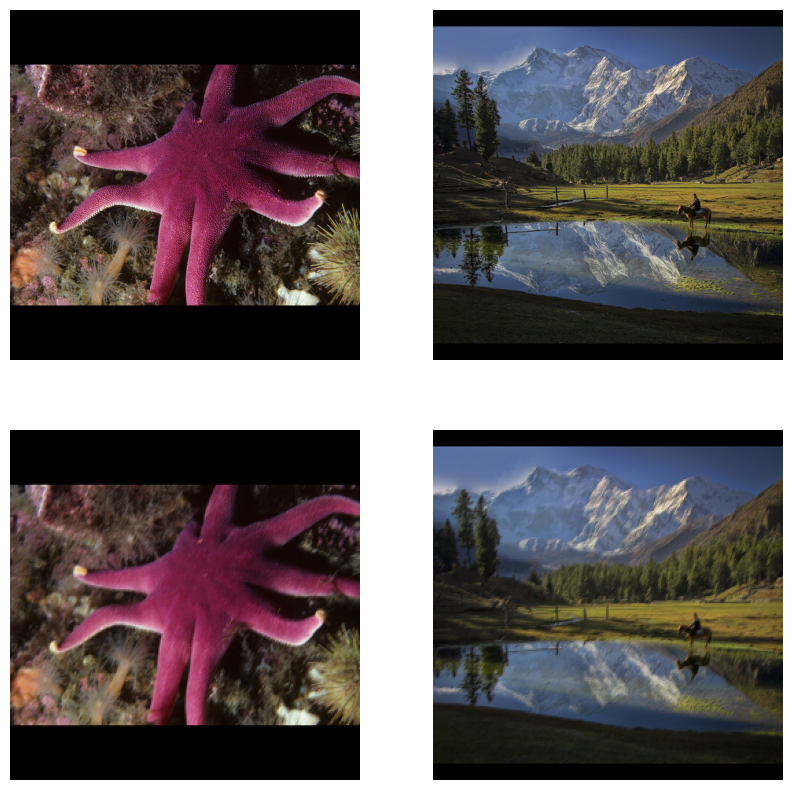

In [17]:
show_sample_images(hr_images_train, lr_un_images_train, sample_images)

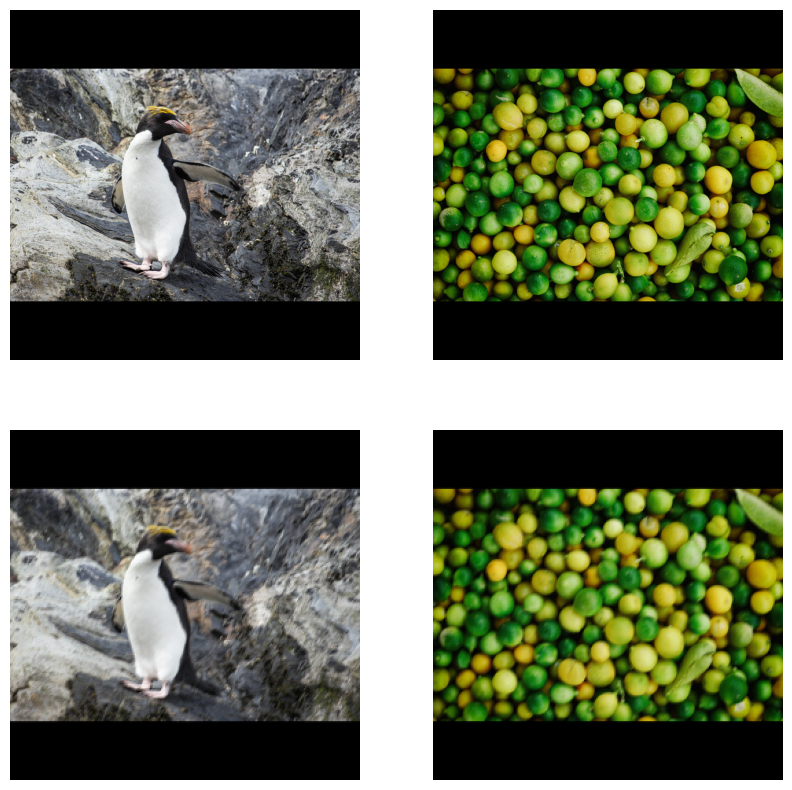

In [18]:
show_sample_images(hr_images_val, lr_un_images_val, sample_images)